In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(11, 4)})

In [2]:
data = pd.read_pickle("aggreg_PRODUCTION_data.pkl")
data.Date = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data=data.set_index('Date')

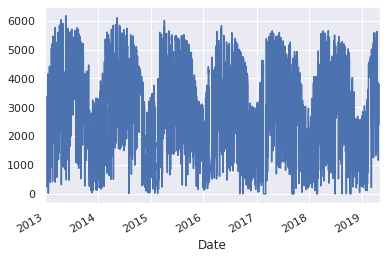

In [3]:
data.Energy_Generated=pd.to_numeric(data.Energy_Generated)
data.Energy_Generated.plot()

In [4]:
data['month'] = data.index.month
data['year'] = data.index.year
data['Weekday_Name'] = data.index.weekday_name
#data = data.reset_index()
#data

In [5]:
train_data = data[data.index < '2018-12-31']
test_data =data[data.index > '2018-12-31']

Date
2013-01-31    1567.161290
2013-02-28    2438.821429
2013-03-31    3316.366667
2013-04-30    3445.241379
2013-05-31    2819.000000
                 ...     
2018-08-31    3514.766667
2018-09-30    3503.866667
2018-10-31    1807.322581
2018-11-30    1729.866667
2018-12-31    1536.466667
Freq: M, Name: Energy_Generated, Length: 72, dtype: float64


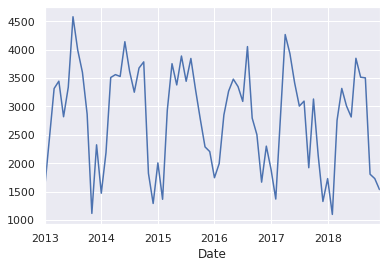

In [6]:
##Resampling 
#monthly_data_mean = data.groupby(['year','month']).mean().reset_index()
all_monthly_data_mean = data.Energy_Generated.resample('M').mean()
monthly_data_mean = train_data.Energy_Generated.resample('M').mean()
monthly_data_median = train_data.Energy_Generated.resample('M').median()
monthly_data_sum = train_data.Energy_Generated.resample('M').sum()
print(monthly_data_mean)
monthly_data_mean.plot()
#monthly_data_median.plot()
#monthly_data_sum.plot()

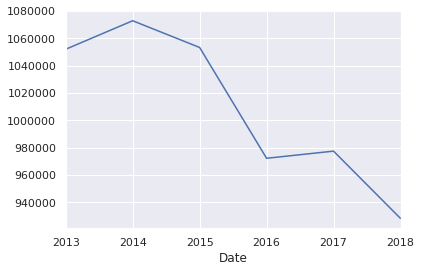

In [7]:
annual_data_sum=train_data.Energy_Generated.resample('A').sum()
annual_data_sum.plot()

In [8]:
##Rolling window
energy_28d = train_data.Energy_Generated.rolling(28, center=True).mean()
energy_365d = train_data.Energy_Generated.rolling(window=365, center=True, min_periods=360).mean()

<Figure size 432x288 with 0 Axes>

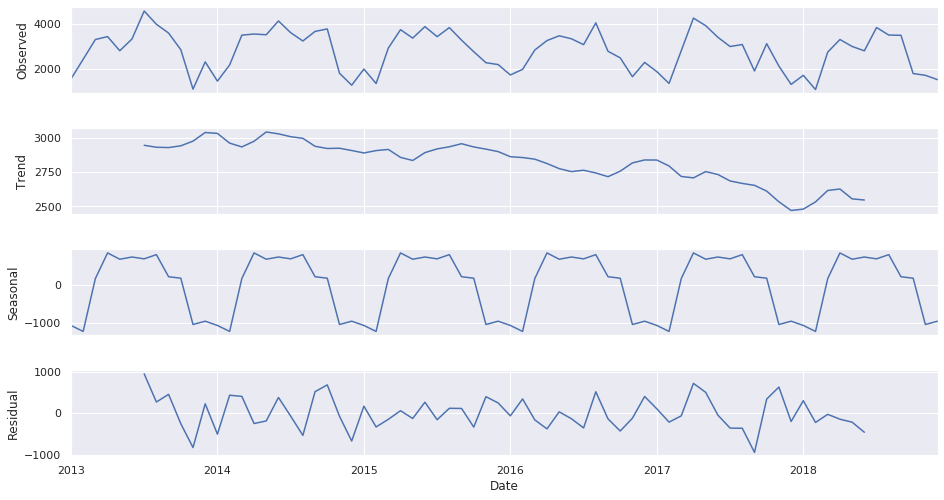

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
energy_28d = energy_28d.dropna()
decomposition = seasonal_decompose(monthly_data_mean, freq=12) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):  
    #Determing rolling statistics
    rolmean = timeseries.rolling(12, center=True).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


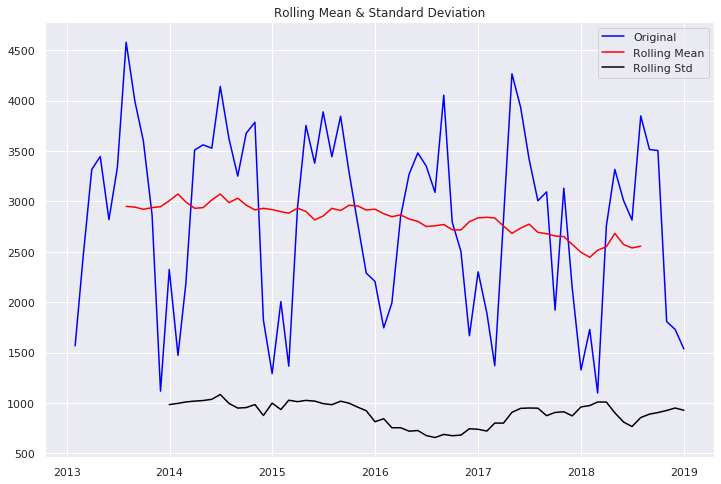

Results of Dickey-Fuller Test:
Test Statistic                 -0.613552
p-value                         0.867890
#Lags Used                     12.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [11]:
test_stationarity(monthly_data_mean)

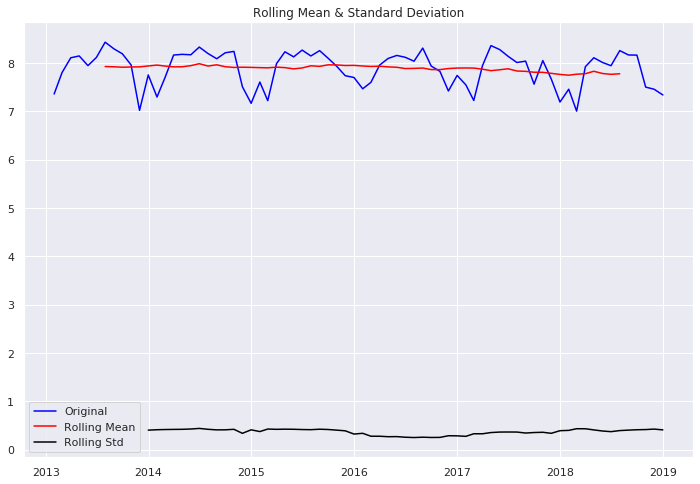

Results of Dickey-Fuller Test:
Test Statistic                 -0.253173
p-value                         0.931880
#Lags Used                     12.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [12]:
monthly_data_mean_log= monthly_data_mean.apply(lambda x: np.log(x))  
test_stationarity(monthly_data_mean_log)

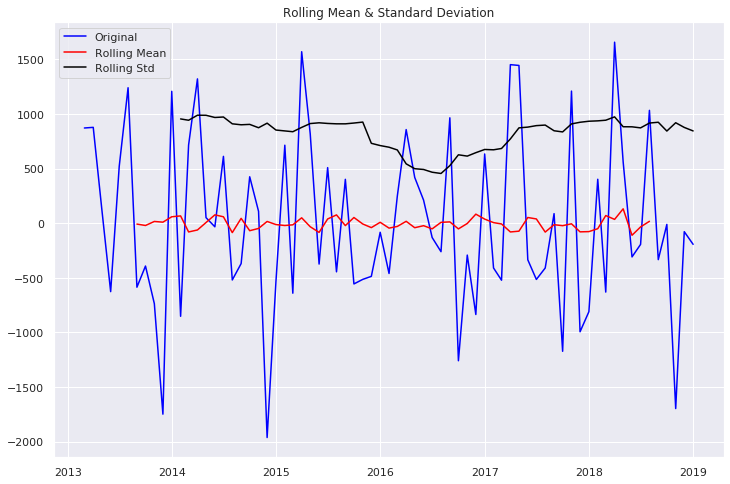

Results of Dickey-Fuller Test:
Test Statistic                -5.785933e+00
p-value                        4.999591e-07
#Lags Used                     1.200000e+01
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64


In [13]:
monthly_data_mean_first_diff = monthly_data_mean - monthly_data_mean.shift(1)  
test_stationarity(monthly_data_mean_first_diff.dropna(inplace=False))

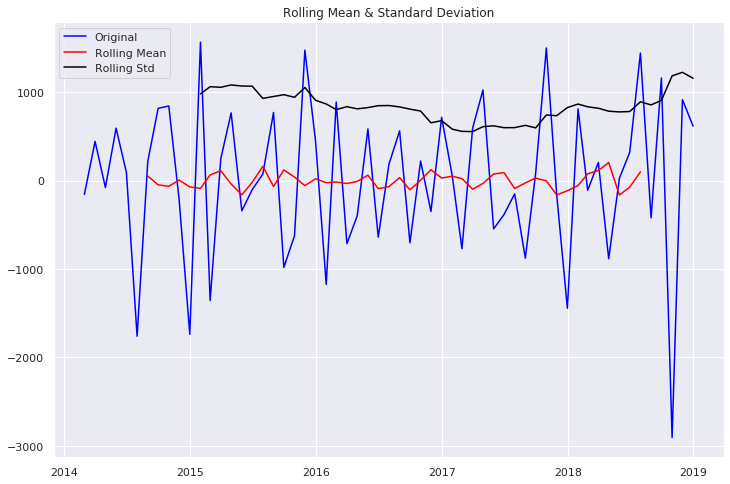

Results of Dickey-Fuller Test:
Test Statistic                -6.572223e+00
p-value                        7.883918e-09
#Lags Used                     4.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


In [14]:
monthly_data_mean_seasonal_first_difference = monthly_data_mean_first_diff - monthly_data_mean_first_diff.shift(12)  
test_stationarity(monthly_data_mean_seasonal_first_difference.dropna(inplace=False))

/home/zhe/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


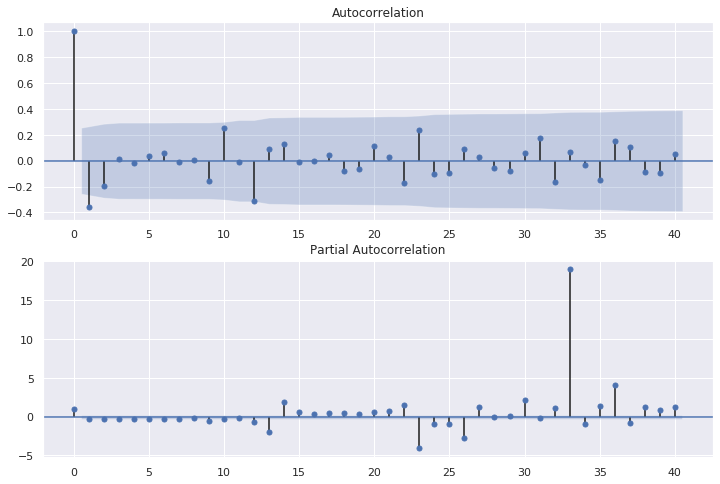

In [15]:
import statsmodels.api as sm 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

Text(0.5, 1.0, 'Trends in Generated Energy')

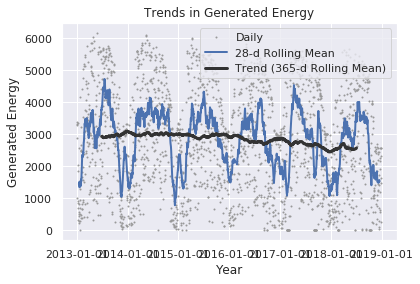

In [16]:
import matplotlib.dates as mdates
# Plot daily, 28-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(train_data.Energy_Generated, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(energy_28d, linewidth=2, label='28-d Rolling Mean')
ax.plot(energy_365d, color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Generated Energy')
ax.set_title('Trends in Generated Energy')

[1441.25       1494.53571429 1507.46428571 ... 1510.78571429 1553.71428571
 1572.17857143]


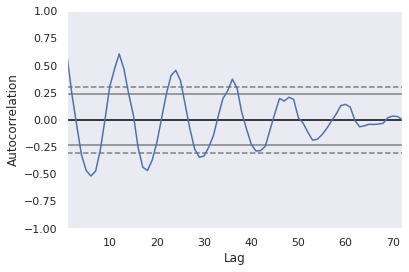

In [17]:
from pandas.plotting import autocorrelation_plot
energy_28d = energy_28d.dropna()
autocorrelation_plot(monthly_data_mean)
print(energy_28d.values)
##Boxplot
#fig, axes = plt.subplots(6, 1, figsize=(11, 10), sharex=True)
#for name, ax in zip([2013,2014,2015,2016,2017,2018], axes):
    #new_data = pd.DataFrame()
    #new_data['month'] = data[(data.year == name)].month.values
    #new_data['Weekday_Name'] = data[(data.year == name)]['Weekday_Name'].values
    #new_data['generated_energy'] = data[(data.year == name)].Energy_Generated.values
    #ax = sns.boxplot(data=new_data, x='month',y="generated_energy",ax=ax)
    #ax.set_ylabel('energy')
    #ax.set_title(str(name))
    #if ax != axes[-1]:
        #ax.set_xlabel('')

In [18]:
monthly_data_mean.count()

72

In [19]:
#SARIMA
mod = sm.tsa.statespace.SARIMAX(monthly_data_mean, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                   Energy_Generated   No. Observations:                   72
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -472.888
Date:                            Wed, 09 Oct 2019   AIC                            951.775
Time:                                    09:14:13   BIC                            958.008
Sample:                                01-31-2013   HQIC                           954.208
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0363      0.289     -0.125      0.900      -0.603       0.531
ma.S.L12      -0.8160      0.519   

In [20]:
test_monthly_data_mean = test_data.Energy_Generated.resample('M').mean()

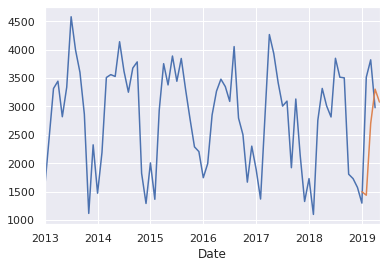

In [21]:
forecast_values = results.predict(start = 72, end=76, dynamic= True)
all_monthly_data_mean.plot()
forecast_values.plot()

In [30]:
from sklearn.metrics import mean_squared_error
print(forecast_values,test_monthly_data_mean)
print(mean_squared_error(test_monthly_data_mean.values, forecast_values.values[:4])**1/2)

2019-01-31    1499.223326
2019-02-28    1437.868258
2019-03-31    2701.744809
2019-04-30    3304.166535
2019-05-31    3076.945650
Freq: M, dtype: float64 Date
2019-01-31    1298.419355
2019-02-28    3514.285714
2019-03-31    3820.903226
2019-04-30    2978.137931
Freq: M, Name: Energy_Generated, dtype: float64
713830.2373376888


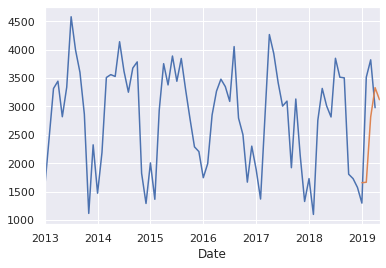

In [31]:
#Holt Winter’s Exponential Smoothing (HWES)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# fit model
model = ExponentialSmoothing(monthly_data_mean,seasonal='mul', seasonal_periods=12)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(start=72, end=76)
all_monthly_data_mean.plot()
yhat.plot()

In [32]:
from sklearn.metrics import mean_squared_error
print(yhat,test_monthly_data_mean)
print(mean_squared_error(test_monthly_data_mean.values, yhat.values[:4])**1/2)

2019-01-31    1657.613933
2019-02-28    1665.667911
2019-03-31    2816.953403
2019-04-30    3330.699575
2019-05-31    3118.880081
Freq: M, dtype: float64 Date
2019-01-31    1298.419355
2019-02-28    3514.285714
2019-03-31    3820.903226
2019-04-30    2978.137931
Freq: M, Name: Energy_Generated, dtype: float64
584827.9359344945


In [33]:
from fbprophet import Prophet

In [34]:
monthly_data_mean = monthly_data_mean.reset_index()
monthly_data_mean = monthly_data_mean.rename(columns={'Date': 'ds','Energy_Generated': 'y'})

In [35]:
#Prophet
model=Prophet(interval_width=0.95, yearly_seasonality=True, daily_seasonality=True)

In [36]:
model.fit(monthly_data_mean)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [37]:
#print(monthly_data_mean)
future_dates = model.make_future_dataframe(periods=6, freq='MS')
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
73,2019-02-01,1126.937969,378.371265,1894.747031
74,2019-03-01,1860.883076,1093.450261,2691.201559
75,2019-04-01,2550.662700,1777.436564,3326.388645
76,2019-05-01,3126.878165,2378.115834,3931.576363
77,2019-06-01,3241.306632,2492.565323,4028.895264


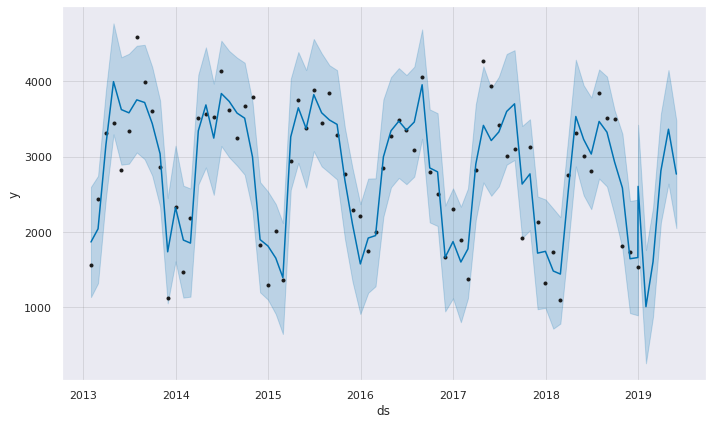

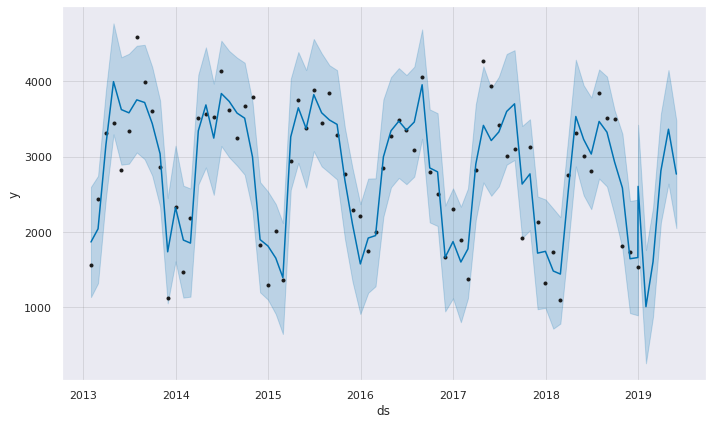

In [24]:
model.plot(forecast,uncertainty=True)

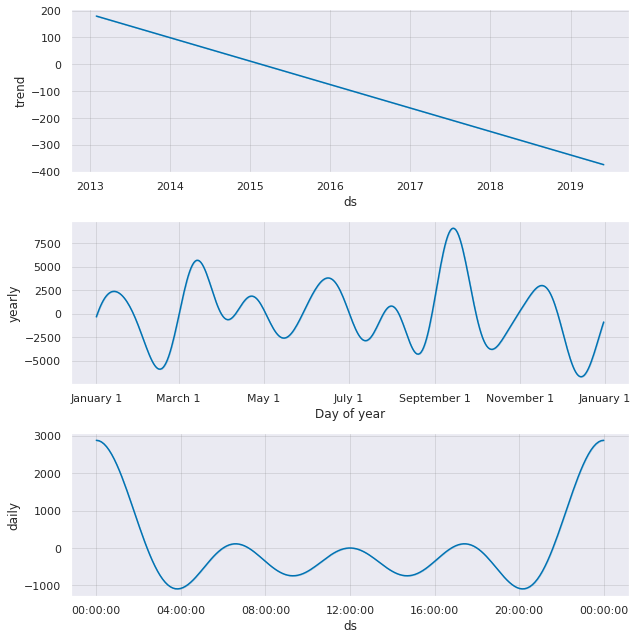

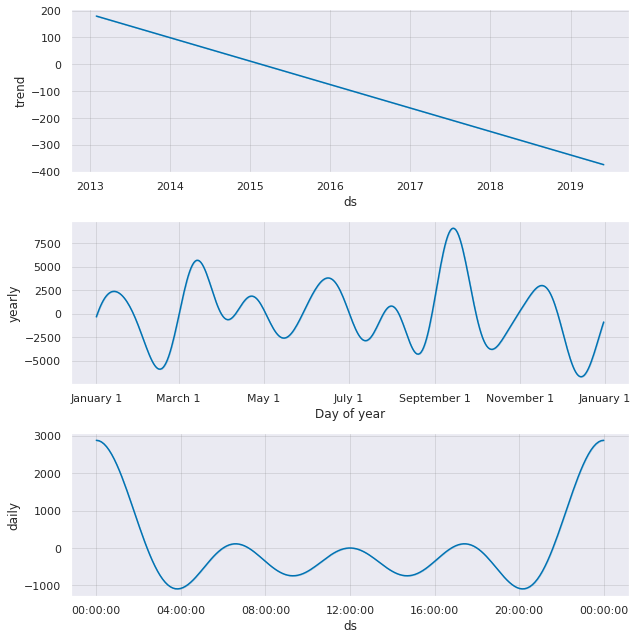

In [38]:
model.plot_components(forecast)

In [40]:
print(forecast[['yhat']].tail(),test_monthly_data_mean)
from sklearn.metrics import mean_squared_error
print(mean_squared_error(test_monthly_data_mean.values, forecast[['yhat']].tail().values[:4])**1/2)

           yhat
73  1126.937969
74  1860.883076
75  2550.662700
76  3126.878165
77  3241.306632 Date
2019-01-31    1298.419355
2019-02-28    3514.285714
2019-03-31    3820.903226
2019-04-30    2978.137931
Freq: M, Name: Energy_Generated, dtype: float64
549847.5998923884


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


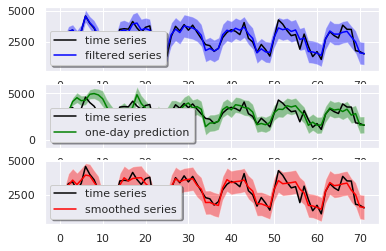

In [43]:
#Bayesian
monthly_data_mean = train_data.Energy_Generated.resample('M').mean()
from pydlm import dlm, trend, seasonality
# A linear trend
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal12 = seasonality(period=12, discount=0.99, name='seasonal12', w=10)
# Build a simple dlm
simple_dlm = dlm(monthly_data_mean) + linear_trend + seasonal12
# Fit the model
simple_dlm.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

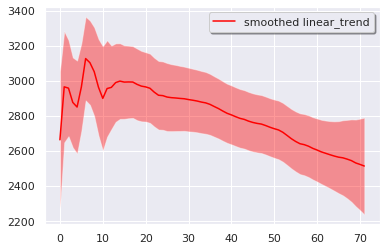

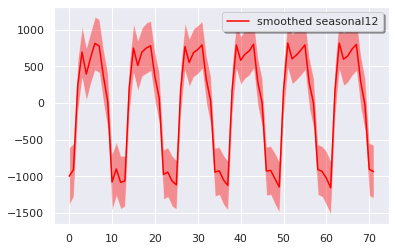

In [45]:
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal12')

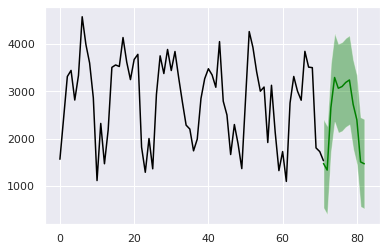

In [46]:
simple_dlm.plotPredictN(date=71, N=12)

In [49]:
forcast_values = simple_dlm.predictN(date=71, N=12)[0][:4]
print(forcast_values)

[1479.3519805745582, 1338.4995276296877, 2656.248270249469, 3295.7711417462265]


In [50]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(test_monthly_data_mean.values, forcast_values)**1/2)

778011.7708936663
